In [1]:
import os
import torch
import numpy as np
import pandas as pd

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, utils
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt


In [2]:
available = torch.cuda.is_available()
curr_device = torch.cuda.current_device()
device = torch.device("cuda:0" if available else "cpu")
device_count = torch.cuda.device_count() 
device_name =  torch.cuda.get_device_name(0)

print(f'Cuda available: {available}')
print(f'Current device: {curr_device}')
print(f'Device: {device}')
print(f'Device count: {device_count}')
print(f'Device name: {device_name}')

Cuda available: True
Current device: 0
Device: cuda:0
Device count: 1
Device name: GeForce GTX 1070


In [3]:
# (Adapted) Code from PyTorch's Resnet impl: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            # norm_layer = nn.BatchNorm2d
            norm_layer = nn.InstanceNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

    
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            #norm_layer = nn.BatchNorm2d
            norm_layer = nn.InstanceNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)

        return out

In [4]:
class MyBatchNorm2d(nn.modules.batchnorm._NormBase):
    ''' Partially based on: 
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/batchnorm.html#BatchNorm2d
        https://discuss.pytorch.org/t/implementing-batchnorm-in-pytorch-problem-with-updating-self-running-mean-and-self-running-var/49314/5 
    '''
    def __init__(
        self,
        num_features,
        eps=1e-5,
        momentum=0.1,
        device=None,
        dtype=None
    ):
        factory_kwargs = {'device': device, 'dtype': dtype, 'affine': False, 'track_running_stats': True}
        super(MyBatchNorm2d, self).__init__(
            num_features, eps, momentum, **factory_kwargs
        )
        
    def _check_input_dim(self, input):
        if input.dim() != 4:
            raise ValueError("expected 4D input (got {}D input)".format(input.dim()))

    def forward(self, input):
        self._check_input_dim(input)
    
        if self.training:
            # Note: Need to detatch `running_{mean,var}` so don't backwards propagate through them
            unbiased_var, tmean = torch.var_mean(input, [0, 2, 3], unbiased=True)
            mean = torch.mean(input, [0, 2, 3]) # along channel axis
            unbiased_var = torch.var(input, [0, 2, 3], unbiased=True) # along channel axis
            running_mean = (1.0 - self.momentum) * self.running_mean.detach() + self.momentum * mean
            
            # Strange: PyTorch impl. of running variance uses biased_variance for the batch calc but
            # *unbiased_var* for the running_var!
            # https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/Normalization.cpp#L190
            running_var = (1.0 - self.momentum) * self.running_var.detach() + self.momentum * unbiased_var
            
            # BK: Modification from the paper to use running mean/var instead of batch mean/var
            # change shape
            current_mean = running_mean.view([1, self.num_features, 1, 1]).expand_as(input)
            current_var = running_var.view([1, self.num_features, 1, 1]).expand_as(input)

            denom = (current_var + self.eps)
            y = (input - current_mean) / denom.sqrt()
           
            self.running_mean = running_mean
            self.running_var = running_var
            
            return y, -0.5 * denom
        else:
            current_mean = self.running_mean.view([1, self.num_features, 1, 1]).expand_as(input)
            current_var = self.running_var.view([1, self.num_features, 1, 1]).expand_as(input)
            
            # Reverse operation
            denom = (current_var + self.eps)
            y = input * denom.sqrt() + current_mean
            return y

In [5]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = tuple([-1] + list(shape))
        
    def forward(self, x):
        return torch.reshape(x, self.shape)

def dense_backbone(shape, network_width):
    input_width = shape[0] * shape[1] * shape[2]
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_width, network_width),
        nn.ReLU(),
        nn.Linear(network_width, input_width),
        Reshape(shape)
    )

def bottleneck_backbone(in_planes, planes):
    return nn.Sequential(
        conv3x3(in_planes, planes),
        BasicBlock(planes, planes),
        BasicBlock(planes, planes),
        BasicBlock(planes, planes),
        BasicBlock(planes, planes),
        #Bottleneck(planes, planes),
        #Bottleneck(planes, planes),
        #Bottleneck(planes, planes),
        #Bottleneck(planes, planes),
        conv3x3(planes, in_planes),
    )

check_mask = {}
check_mask_device = {}
def checkerboard_mask(shape, to_device=True):
    global check_mask, check_mask_device
    if shape not in check_mask:
        check_mask[shape] = 1 - np.indices(shape).sum(axis=0) % 2
        check_mask[shape] = torch.Tensor(check_mask[shape])
        
    if to_device and shape not in check_mask_device:
        check_mask_device[shape] = check_mask[shape].to(device)
        
    return check_mask_device[shape] if to_device else check_mask[shape]

chan_mask = {}
chan_mask_device = {}
def channel_mask(shape, to_device=True):
    assert len(shape) == 3, shape
    assert shape[0] % 2 == 0, shape
    global chan_mask, chan_mask_device
    if shape not in chan_mask:
        chan_mask[shape] = torch.cat([torch.zeros((shape[0] // 2, shape[1], shape[2])),
                                      torch.ones((shape[0] // 2, shape[1], shape[2])),],
                                      dim=0)
        assert chan_mask[shape].shape == shape, (chan_mask[shape].shape, shape)
        
    if to_device and shape not in chan_mask_device:
        chan_mask_device[shape] = chan_mask[shape].to(device)
        
    return chan_mask_device[shape] if to_device else chan_mask[shape]

In [6]:
class NormalizingFlowMNist(nn.Module):
    EPSILON = 1e-5
    
    def __init__(self, num_coupling=6, num_final_coupling=4, planes=64):
        super(NormalizingFlowMNist, self).__init__()
        self.num_coupling = num_coupling
        self.num_final_coupling = num_final_coupling
        self.shape = (3, 32, 32)
        
        self.planes = planes
        self.s = nn.ModuleList()
        self.t = nn.ModuleList()
        self.norms = nn.ModuleList()
        
        # Learnable scalar scaling parameters for outputs of S and T
        self.s_scale = nn.ParameterList()
        self.t_scale = nn.ParameterList()
        self.t_bias = nn.ParameterList()
        self.shapes = []
      
        shape = self.shape
        for i in range(num_coupling):
            self.s.append(bottleneck_backbone(shape[0], planes))
            self.t.append(bottleneck_backbone(shape[0], planes))
            
            self.s_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_bias.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
                          
            torch.nn.init.normal_(self.s_scale[i], std=0.1)
            torch.nn.init.normal_(self.t_scale[i], std=0.1)
            
            self.norms.append(MyBatchNorm2d(shape[0]) if i % 6 <= 2 else None)
            
            self.shapes.append(shape)
           
            if i % 6 == 2:
                shape = (4 * shape[0], shape[1] // 2, shape[2] // 2)
                
            if i % 6 == 5:
                # Factoring out half the channels
                shape = (shape[0] // 2, shape[1], shape[2])
                planes = 2 * planes
       
        # Final coupling layers checkerboard
        for i in range(num_final_coupling):
            self.s.append(bottleneck_backbone(shape[0], planes))
            self.t.append(bottleneck_backbone(shape[0], planes))
            
            self.s_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_bias.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            
            self.shapes.append(shape)
           
        self.validation = False
    
    def validate(self):
        self.validation = True
        self.eval()
        
    def train(self, mode=True):
        nn.Module.train(self, mode)
        if mode:
            self.validation = False

    def forward(self, x):
        if model.training or self.validation:
            s_vals = []
            norm_vals = []
            y_vals = []
            
            for i in range(self.num_coupling):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape) if i % 6 < 3 else channel_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
               
                t = (self.t_scale[i]) * self.t[i](mask * x) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * x))
                y = mask * x + (1 - mask) * (x * torch.exp(s) + t)
                s_vals.append(torch.flatten((1 - mask) * s))
               
                if self.norms[i] is not None:
                    y, norm_loss = self.norms[i](y)
                    norm_vals.append(norm_loss)
                
                if i % 6 == 2:
                    y = torch.nn.functional.pixel_unshuffle(y, 2)
                    
                if i % 6 == 5:
                    factor_channels = y.shape[1] // 2
                    y_vals.append(torch.flatten(y[:, factor_channels:, :, :], 1))
                    y = y[:, :factor_channels, :, :]
                    
                x = y
                
            # Final checkboard coupling
            for i in range(self.num_coupling, self.num_final_coupling):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
               
                t = (self.t_scale[i]) * self.t[i](mask * x) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * x))
                y = mask * x + (1 - mask) * (x * torch.exp(s) + t)
                s_vals.append(torch.flatten((1 - mask) * s))
                
                x = y

            y_vals.append(torch.flatten(y, 1))
            
            # Return outputs and vars needed for determinant
            return (torch.flatten(torch.cat(y_vals, 1), 1),
                    torch.cat(s_vals), 
                    torch.cat([torch.flatten(v) for v in norm_vals]),
                    torch.cat([torch.flatten(s) for s in self.s_scale]))
        else:
            y = x
            y_remaining = y
           
            layer_vars = np.prod(self.shapes[-1])
            y = torch.reshape(y_remaining[:, -layer_vars:], (-1,) + self.shapes[-1])
            y_remaining = y_remaining[:, :-layer_vars]
            
            # Reversed final checkboard coupling
            for i in reversed(range(self.num_coupling, self.num_final_coupling)):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
              
                t = (self.t_scale[i]) * self.t[i](mask * y) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * y))
                x = mask * y + (1 - mask) * ((y - t) * torch.exp(-s))
               
                y = x           
          
            layer_vars = np.prod(shape)
            y = torch.cat((y, torch.reshape(y_remaining[:, -layer_vars:], (-1,) + shape)), 1)
            y_remaining = y_remaining[:, :-layer_vars]
            
            # Multi-scale coupling layers
            for i in reversed(range(self.num_coupling)):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape) if i % 6 < 3 else channel_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
              
                if self.norms[i] is not None:
                    y = self.norms[i](y)
                t = (self.t_scale[i]) * self.t[i](mask * y) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * y))
                x = mask * y + (1 - mask) * ((y - t) * torch.exp(-s))
               
                if i % 6 == 3:
                    x = torch.nn.functional.pixel_shuffle(x, 2)
                    
                y = x
                
                if i > 0 and i % 6 == 0:
                    layer_vars = np.prod(shape)
                    y = torch.cat((y, torch.reshape(y_remaining[:, -layer_vars:], (-1,) + shape)), 1)
                    y_remaining = y_remaining[:, :-layer_vars]
            
            assert np.prod(y_remaining.shape) == 0
            
            return x

In [7]:
PI = torch.tensor(np.pi).to(device)
def loss_fn(y, s, norms, scale, batch_size):
    # -log(zero-mean gaussian) + log determinant
    # -log p_x = log(pz(f(x))) + log(det(\partial f/\partial x))
    # -log p_x = 0.5 * y**2 + s1 + s2 + ... + batch_norm_scalers + l2_regularizers(scale)
    logpx = -torch.sum(0.5 * torch.log(2 * PI) + 0.5 * y**2)
    det = torch.sum(s)
    norms = torch.sum(norms)
    reg = 5e-5 * torch.sum(scale ** 2)
    loss = -(logpx + det + norms) + reg
    return torch.div(loss, batch_size)

# MNist Training

In [8]:
def pre_process(x):
    # Convert back to integer values
    x = x * 255.
    
    # Add random uniform [0, 1] noise to get a proper likelihood estimate
    # https://bjlkeng.github.io/posts/a-note-on-using-log-likelihood-for-generative-models/
    x = x + torch.rand(x.shape)
    
    return x / 255

def post_process(x):
    return torch.clip(x, min=0, max=1)

In [9]:
train_dataset = datasets.CIFAR10('data', train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                               ]))

# TODO FIX ME
debug_data = []
for i, x in enumerate(train_dataset):
    if i >= 10:
        break
    debug_data.append(x)

test_dataset = datasets.CIFAR10('data', train=False, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                              ]))

Files already downloaded and verified
Files already downloaded and verified


In [10]:
def train_loop(dataloader, model, loss_fn, optimizer, report_iters=10, num_pixels=3*32*32):
    size = len(dataloader)
    prev = []
    for batch, (X, _) in enumerate(dataloader):
        # Transfer to GPU
        X = pre_process(X)
        X = X.to(device)
        
        # Compute prediction and loss
        y, s, norms, scale = model(X)
        loss = loss_fn(y, s, norms, scale, batch_size)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        prev = [(name, x, x.grad) for name, x in model.named_parameters(recurse=True)]
        optimizer.step()

        if batch % report_iters == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:.2f}; {loss / num_pixels / np.log(2):>.2f}  [{current:>5d}/{size:>5d}]")
            
def test_loop(dataloader, model, loss_fn, num_pixels=3*32*32):
    size = len(dataloader)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        model.validate()
        for X, _ in dataloader:
            X = pre_process(X)
            X = X.to(device)
            y, s, norms, scale = model(X)
            test_loss += loss_fn(y, s, norms, scale, batch_size)
        model.train()

    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:.2f}; {test_loss / num_pixels / np.log(2):.2f} \n")

In [11]:
learning_rate = 0.001
batch_size = 20
epochs = 200

model = NormalizingFlowMNist(12, 32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

for t in range(epochs):
    # TODO FIX ME
    #train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    train_loader = DataLoader(debug_data, batch_size=batch_size, shuffle=True)
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    
    # TODO FIX ME
    #test_loop(test_loader, model, loss_fn)
    
    #scheduler.step()

print("Done!")

Epoch 1
-------------------------------
loss: 4758.34; 2.23  [    0/    1]
Epoch 2
-------------------------------
loss: 4458.50; 2.09  [    0/    1]
Epoch 3
-------------------------------
loss: 4217.98; 1.98  [    0/    1]
Epoch 4
-------------------------------
loss: 4049.35; 1.90  [    0/    1]
Epoch 5
-------------------------------
loss: 3914.13; 1.84  [    0/    1]
Epoch 6
-------------------------------
loss: 3842.39; 1.80  [    0/    1]
Epoch 7
-------------------------------
loss: 3792.92; 1.78  [    0/    1]
Epoch 8
-------------------------------
loss: 3743.88; 1.76  [    0/    1]
Epoch 9
-------------------------------
loss: 3732.79; 1.75  [    0/    1]
Epoch 10
-------------------------------
loss: 3673.50; 1.73  [    0/    1]
Epoch 11
-------------------------------
loss: 3641.68; 1.71  [    0/    1]
Epoch 12
-------------------------------
loss: 3610.18; 1.70  [    0/    1]
Epoch 13
-------------------------------
loss: 3594.51; 1.69  [    0/    1]
Epoch 14
------------

loss: 2219.44; 1.04  [    0/    1]
Epoch 110
-------------------------------
loss: 2202.27; 1.03  [    0/    1]
Epoch 111
-------------------------------
loss: 2188.30; 1.03  [    0/    1]
Epoch 112
-------------------------------
loss: 2176.86; 1.02  [    0/    1]
Epoch 113
-------------------------------
loss: 2156.09; 1.01  [    0/    1]
Epoch 114
-------------------------------
loss: 2138.50; 1.00  [    0/    1]
Epoch 115
-------------------------------
loss: 2129.43; 1.00  [    0/    1]
Epoch 116
-------------------------------
loss: 2113.24; 0.99  [    0/    1]
Epoch 117
-------------------------------
loss: 2112.06; 0.99  [    0/    1]
Epoch 118
-------------------------------
loss: 2099.58; 0.99  [    0/    1]
Epoch 119
-------------------------------
loss: 2083.17; 0.98  [    0/    1]
Epoch 120
-------------------------------
loss: 2087.33; 0.98  [    0/    1]
Epoch 121
-------------------------------
loss: 2131.98; 1.00  [    0/    1]
Epoch 122
-------------------------------

# Debug - Check that foward/reverse are (about) equal

In [12]:
# DEBUG - Check

model.train()
with torch.no_grad():
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) #shuffle=True)
    for x, _ in train_loader:
        x_pre = pre_process(x).to(device)
        y, s, norms, scale = model(x_pre)
        print(y.shape)
        break

model.eval()
with torch.no_grad():
    xp = model(y)
    x_post = post_process(xp)

diff = x.to(device) - x_post
torch.any(torch.abs(diff) > 1 / 255)

torch.Size([20, 3072])


tensor(True, device='cuda:0')

In [13]:
print(diff.shape)

for i in range(batch_size):
    if torch.any(torch.abs(diff[i]) > 1 / 255):
        #print(diff[i])
        for j in range(32):
            for k in range(32):
                if torch.any(torch.abs(diff[i, 0, j, k]) > 1 / 25):
                    print(i, 1, j, k, diff[i, 0, j, k].cpu().numpy())
                    break
        break

torch.Size([20, 3, 32, 32])


count    61440.000000
mean         0.035070
std          3.744159
min        -43.943455
25%         -0.672753
50%         -0.018113
75%          0.733390
max         47.325050
dtype: float64


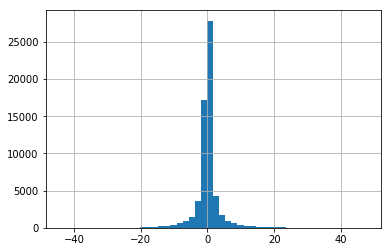

In [14]:
s = pd.Series(torch.flatten(y).cpu().numpy())
print(s.describe())
s.hist(bins=50)

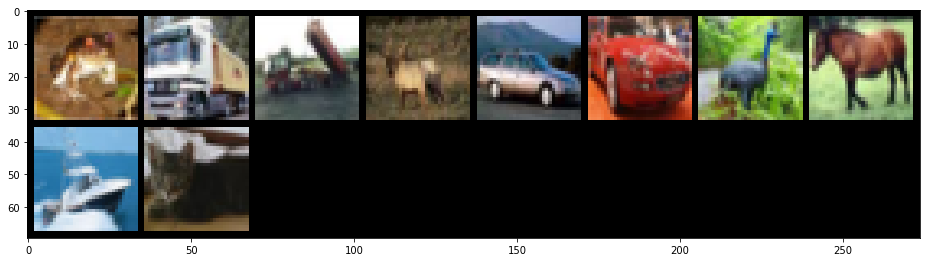

In [15]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(16, 16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(utils.make_grid([x for x, _ in debug_data]))

In [16]:
model.eval()
with torch.no_grad():
    X = torch.Tensor(torch.randn((1, 32 * 32 * 3))).to(device)
    Y = model(X)
    samples = post_process(Y).cpu().numpy()

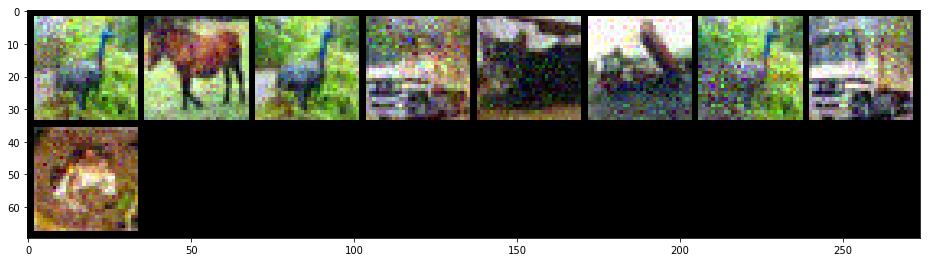

In [17]:
model.eval()

cols, rows = 3, 3
with torch.no_grad():
    X = torch.Tensor(torch.normal(torch.zeros(cols * rows, 32 * 32 * 3),
                                  torch.ones(cols * rows, 32 * 32 * 3))).to(device)
    Y = model(X)
    samples = post_process(Y).cpu()

imshow(utils.make_grid(samples))

# 2022-03-01

* Looks like with minimal modifications I can overfit (sort of) on a 10 images sample (12 coupling + 32 initial features).
* Changes:
  * 4 residual blocks
* I think the graininess might be the end range effect (i.e < 0 and > 256) -- using the transform they recommend in the paper might overcome this limitation.

NEXT: 

* Play around with pre/post processing transform
* Increase training dataset size

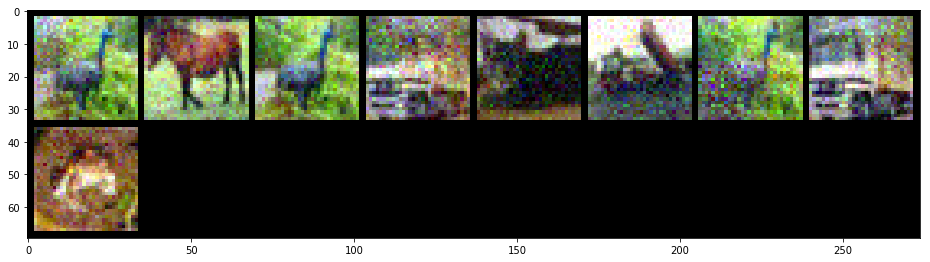
